In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# TensorFlow & Keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Concatenate
from tensorflow.keras.layers import (Input, Dense, Flatten, Dropout, GlobalAveragePooling2D)
from tensorflow.keras.applications import Xception, DenseNet121, InceptionV3
from tensorflow.keras.optimizers import Adamax, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Precision, Recall

# Scikit-Learn
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, SelectFromModel, f_classif
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, 
    ExtraTreesClassifier, VotingClassifier, StackingClassifier
)

# Boosting Libraries
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Evaluation Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
)

#for parallel threading
from joblib import parallel_backend
import cv2

#Model saving to disk
import pickle

# Suppress warnings
warnings.filterwarnings("ignore")

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPUs detected: {len(gpus)}")
    except RuntimeError as e:
        print(f"Error setting GPU memory growth: {e}")
else:
    print("No GPUs detected.")

GPUs detected: 1


In [2]:
def data_frame(path):
    class_paths = []
    classes = []

    for label in os.listdir(path):
        class_dir = os.path.join(path, label)
        if os.path.isdir(class_dir):  # Ensure it's a directory
            for image in os.listdir(class_dir):
                class_paths.append(os.path.join(class_dir, image))
                classes.append(label)

    df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return df

In [4]:
dataframe = data_frame('/kaggle/input/blood-8-type-all-dataset-aug/normalized_output of Blood Cancer macenko')
from sklearn.model_selection import train_test_split
train_dataframe, temp_dataframe = train_test_split(dataframe, 
                                                   test_size=0.2, 
                                                   random_state=42, 
                                                   stratify=dataframe['Class'])
Validation_dataframe, test_dataframe = train_test_split(temp_dataframe, 
                                                        test_size=0.5, 
                                                        random_state=42, 
                                                        stratify=temp_dataframe['Class'])
print(f"Train size: {len(train_dataframe)}, Validation size: {len(Validation_dataframe)}, Test size: {len(test_dataframe)}")

Train size: 21440, Validation size: 2680, Test size: 2680


In [3]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
EPOCH = 50
img_shape=(224,224,3)
labels = [
    "basophil",
    "eosinophil",
    "erythroblast",
    "ig",
    "lymphocyte",
    "monocyte",
    "neutrophil",
    "platelet"
]

In [4]:
def apply_clahe(img):
    """Apply CLAHE after Adaptive Gray World Normalization."""
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=0.03, tileGridSize=(8,8))
    l = clahe.apply(l)
    clahe_img = cv2.merge((l, a, b))
    return cv2.cvtColor(clahe_img, cv2.COLOR_LAB2RGB)

def preprocess_image(img):
    """First apply Adaptive Gray World, then CLAHE (No Normalization)."""
    img = img.astype(np.uint8)  # Ensure correct data type
    img = apply_clahe(img)  # Step 2: CLAHE
    img = (img - np.mean(img)) / (np.std(img) + 1e-8) # step: 3: z score normalization
    return img  

In [5]:
def preprocess_image2(image):
    # Convert to float32
    img = image.astype(np.float32)

    # Apply Z-score Normalization
    #img = (img - np.mean(img)) / (np.std(img) + 1e-8)

    # Min-Max Scaling (for CLAHE)
    img = (img - np.min(img)) / (np.ptp(img) + 1e-8)  # np.ptp = max - min
    #img = (img * 255).astype(np.uint8)  # Convert to uint8 for CLAHE

    # Apply CLAHE to each channel independently
    #clahe = cv2.createCLAHE(clipLimit=0.02, tileGridSize=(8, 8))
    #img_clahe = np.zeros_like(img)
    
    #for i in range(3):  # Apply CLAHE on each channel separately
        #img_clahe[..., i] = clahe.apply(img[..., i])

    # Convert back to float32 (normalize to [0,1])
    #img_clahe = img_clahe.astype(np.float32) / 255.0  

    return img

In [8]:
data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_image2,
    rotation_range=10,
    shear_range=0.1,
    zoom_range=0.05,
    fill_mode='nearest',
)
test_data_generator = ImageDataGenerator(preprocessing_function=preprocess_image2)


train_data = data_generator.flow_from_dataframe(train_dataframe, x_col='Class Path',
                                  y_col='Class', batch_size=BATCH_SIZE,
                                  target_size=IMG_SIZE, seed=42)

validation_data = data_generator.flow_from_dataframe(Validation_dataframe, x_col='Class Path',
                                     y_col='Class', batch_size=BATCH_SIZE,
                                     target_size=IMG_SIZE, seed=42)

test_data = test_data_generator.flow_from_dataframe(test_dataframe, x_col='Class Path',
                                  y_col='Class', batch_size=BATCH_SIZE,
                                  target_size=IMG_SIZE, shuffle=False, seed=42)

Found 21440 validated image filenames belonging to 8 classes.
Found 2680 validated image filenames belonging to 8 classes.
Found 2680 validated image filenames belonging to 8 classes.


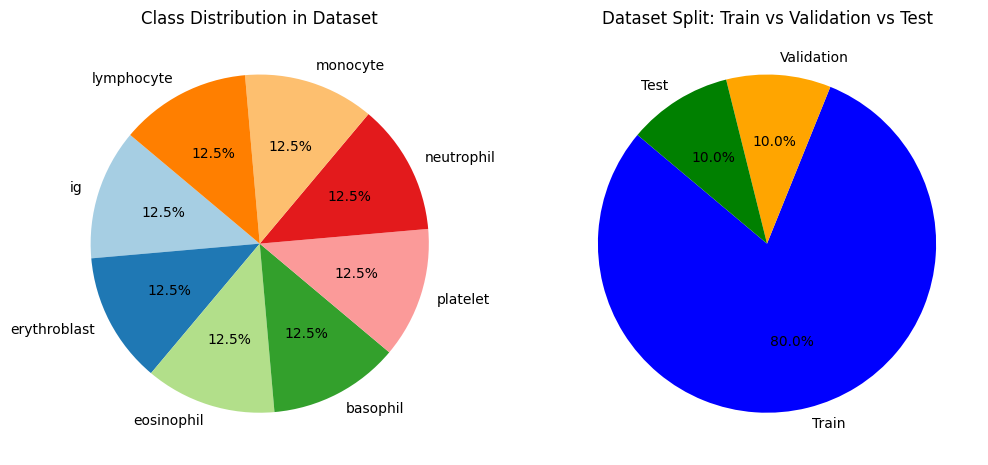

In [9]:
train_class_counts = train_dataframe['Class'].value_counts()

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.pie(train_class_counts, labels=train_class_counts.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title("Class Distribution in Dataset")

# Second Pie Chart: Train, Validation, Test Split
train_size = len(train_dataframe)
val_size = len(Validation_dataframe)
test_size = len(test_dataframe)

plt.subplot(1, 2, 2)
plt.pie([train_size, val_size, test_size], labels=['Train', 'Validation', 'Test'], autopct='%1.1f%%', startangle=140, colors=['blue', 'orange', 'green'])
plt.title("Dataset Split: Train vs Validation vs Test")

plt.show()

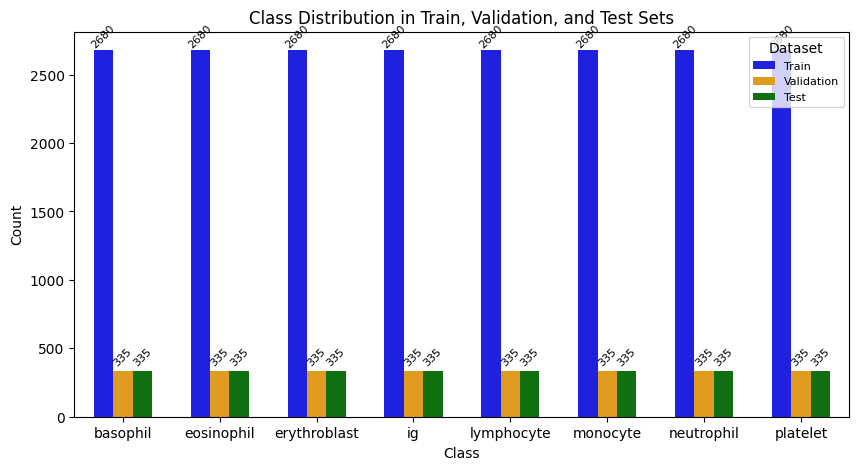

In [10]:
# Count occurrences of each class in train, validation, and test datasets
train_counts = train_dataframe['Class'].value_counts().sort_index()
val_counts = Validation_dataframe['Class'].value_counts().sort_index()
test_counts = test_dataframe['Class'].value_counts().sort_index()

# Combine into a DataFrame with the index kept as a column
data_counts = pd.DataFrame({
    'Class': train_counts.index,
    'Train': train_counts.values,
    'Validation': val_counts.values,
    'Test': test_counts.values
}).melt(id_vars='Class', var_name='Dataset', value_name='Count')

# Plot the bar chart
plt.figure(figsize=(10, 5))
ax = sns.barplot(x='Class', y='Count', hue='Dataset', data=data_counts, palette=['blue', 'orange', 'green'], width=0.6)

# Add count labels on top of the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                fontsize=8, color='black', 
                xytext=(0, 10), textcoords='offset points',
                rotation=45)

# Add labels and title
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Distribution in Train, Validation, and Test Sets")

# Move the legend to the upper right
plt.legend(title="Dataset", loc='upper right', fontsize=8)

# Adjust x-tick rotation and grid
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='none', alpha=0.7)

# Show the plot
plt.show()

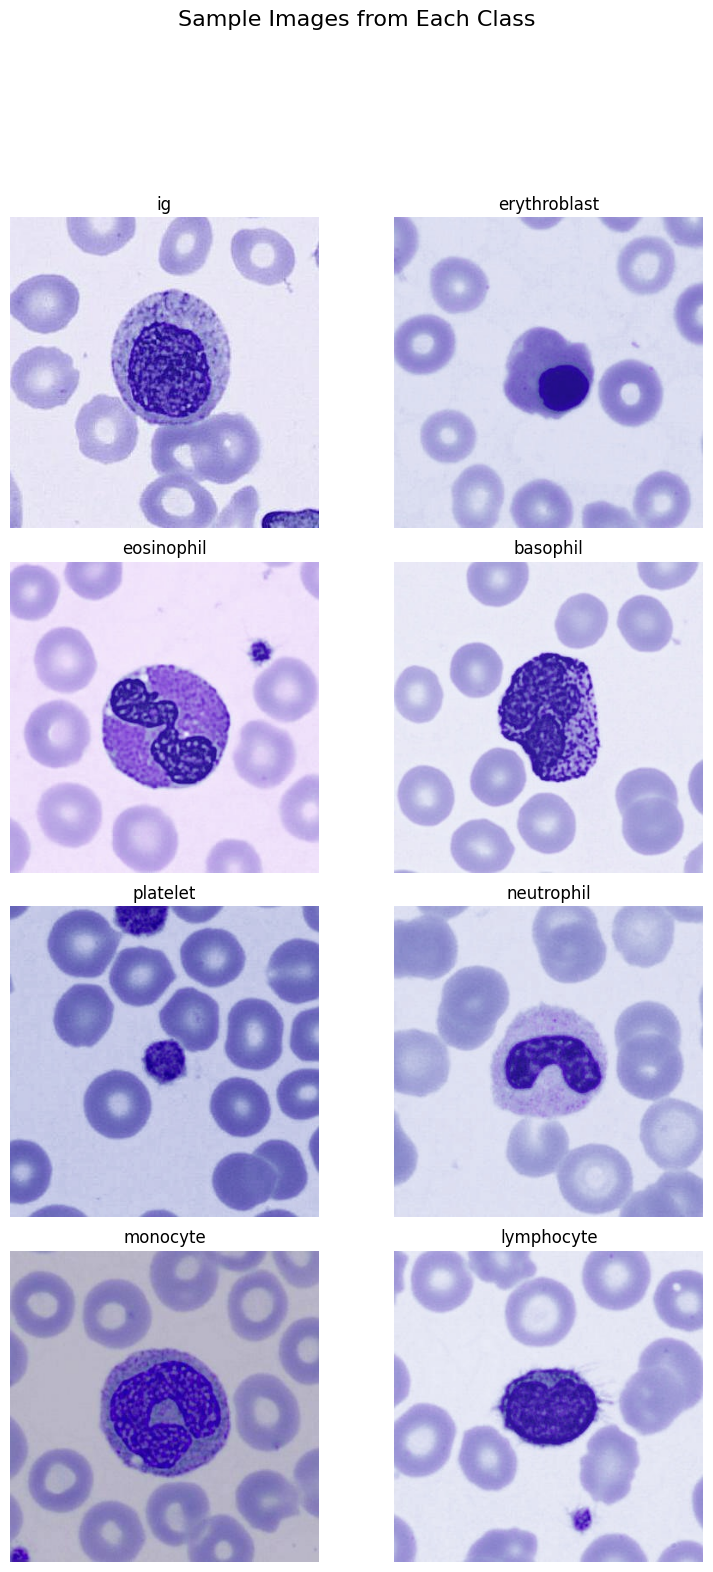

In [11]:
import math

# Get unique classes
unique_classes = train_dataframe['Class'].unique()

# Calculate number of rows and columns based on the number of classes
num_classes = len(unique_classes)
cols = 2  # Set the number of columns (you can change this as per your requirement)
rows = math.ceil(num_classes / cols)  # Calculate the required rows

# Create a figure
plt.figure(figsize=(cols * 4, rows * 4))  # Adjust the size based on the number of images

for i, class_name in enumerate(unique_classes):
    # Get one image path from each class
    img_path = train_dataframe[train_dataframe['Class'] == class_name]['Class Path'].iloc[0]
    
    # Load image
    img = plt.imread(img_path)
    
    # Plot the image
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(class_name, fontsize=12)

plt.suptitle("Sample Images from Each Class", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.85)  # Adjust the top to fit the suptitle
plt.show()


In [6]:
@tf.keras.utils.register_keras_serializable(package="Custom", name="F1Score")
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * (p * r) / (p + r + tf.keras.backend.epsilon())

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

In [13]:
base_model = tf.keras.applications.Xception(include_top= False, weights= "imagenet",
                            input_shape= img_shape, pooling= 'max')

inputs = Input(shape = img_shape)
x = base_model(inputs)
x = Flatten()(x)
x = Dropout(rate= 0.3)(x)
x = Dense(128, activation= 'relu')(x)
x = Dropout(rate= 0.25)(x)
x = Dense(8, activation= 'softmax')(x)
Xmodel = Model(inputs, x)

base_model.trainable = True
for layer in base_model.layers[:50]:
    layer.trainable = False

Xmodel.compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy',
                        Precision(name='precision'),
                        Recall(name='recall'),
                        F1Score()])

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [14]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint

class RestoreBestValidationModel(Callback):
    def __init__(self):
        super(RestoreBestValidationModel, self).__init__()
        self.best_val_acc = -1
        self.best_epoch = -1
        self.best_weights = None

    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs.get('val_accuracy')
        if val_acc is not None:
            if val_acc > self.best_val_acc or (val_acc == self.best_val_acc and epoch > self.best_epoch):
                self.best_val_acc = val_acc
                self.best_epoch = epoch
                self.best_weights = self.model.get_weights()  
                print(f"Model weights updated at epoch {epoch + 1} with val_accuracy: {val_acc:.4f}")

    def on_train_end(self, logs=None):
        if self.best_weights is not None:
            print(f"Restoring model weights from best epoch {self.best_epoch + 1} with val_accuracy: {self.best_val_acc:.4f}")
            self.model.set_weights(self.best_weights)  

restore_best = RestoreBestValidationModel()

In [15]:
history_X = Xmodel.fit(train_data,
                 epochs=EPOCH,             
                 validation_data=validation_data,
                 callbacks=[restore_best],
                 shuffle= False)

Epoch 1/50
670/670 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.7471 - f1_score: 0.7455 - loss: 0.7384 - precision: 0.8677 - recall: 0.6740Model weights updated at epoch 1 with val_accuracy: 0.9601
670/670 ━━━━━━━━━━━━━━━━━━━━ 374s 511ms/step - accuracy: 0.7473 - f1_score: 0.7457 - loss: 0.7378 - precision: 0.8678 - recall: 0.6743 - val_accuracy: 0.9601 - val_f1_score: 0.9583 - val_loss: 0.1334 - val_precision: 0.9613 - val_recall: 0.9552
Epoch 2/50
670/670 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.9718 - f1_score: 0.9721 - loss: 0.0910 - precision: 0.9764 - recall: 0.9680Model weights updated at epoch 2 with val_accuracy: 0.9795
670/670 ━━━━━━━━━━━━━━━━━━━━ 273s 407ms/step - accuracy: 0.9718 - f1_score: 0.9722 - loss: 0.0910 - precision: 0.9764 - recall: 0.9680 - val_accuracy: 0.9795 - val_f1_score: 0.9809 - val_loss: 0.0561 - val_precision: 0.9824 - val_recall: 0.9795
Epoch 3/50
670/670 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.9851 - f1_score: 0.9851 - loss: 0.0496

In [16]:
# Extract metrics for XCEPTION MODEL
tr_acc_X = history_X.history['accuracy']
tr_loss_X = history_X.history['loss']
tr_per_X = history_X.history['precision']
tr_recall_X = history_X.history['recall']
tr_fscore_X = history_X.history['f1_score']
val_acc_X = history_X.history['val_accuracy']
val_loss_X = history_X.history['val_loss']
val_per_X = history_X.history['val_precision']
val_recall_X = history_X.history['val_recall']
val_fscore_X = history_X.history['val_f1_score']

# Get the best epochs for each metric
index_loss_X = np.argmin(val_loss_X)
loss_lowest_X = val_loss_X[index_loss_X]
index_acc_X = np.argmax(val_acc_X)
acc_highest_X = val_acc_X[index_acc_X]
index_precision_X = np.argmax(val_per_X)
pre_highest_X = val_per_X[index_precision_X]
index_recall_X = np.argmax(val_recall_X)
recall_highest_X = val_recall_X[index_recall_X]
index_fscore_X = np.argmax(val_fscore_X)
fscore_highest_X = val_fscore_X[index_fscore_X]

# Print results
print(f"Lowest Loss: {loss_lowest_X} at index {index_loss_X}")
print(f"Highest Accuracy: {acc_highest_X} at index {index_acc_X}")
print(f"Highest Precision: {pre_highest_X} at index {index_precision_X}")
print(f"Highest Recall: {recall_highest_X} at index {index_recall_X}")
print(f"Highest F1-score: {fscore_highest_X} at index {index_fscore_X}")

# Epochs for plotting
Epochs_X = [i + 1 for i in range(len(tr_acc_X))]

# Define a modern style
plt.style.use('ggplot')

Lowest Loss: 0.023629114031791687 at index 7
Highest Accuracy: 0.9936566948890686 at index 7
Highest Precision: 0.9940254092216492 at index 7
Highest Recall: 0.9932835698127747 at index 7
Highest F1-score: 0.9936542510986328 at index 7


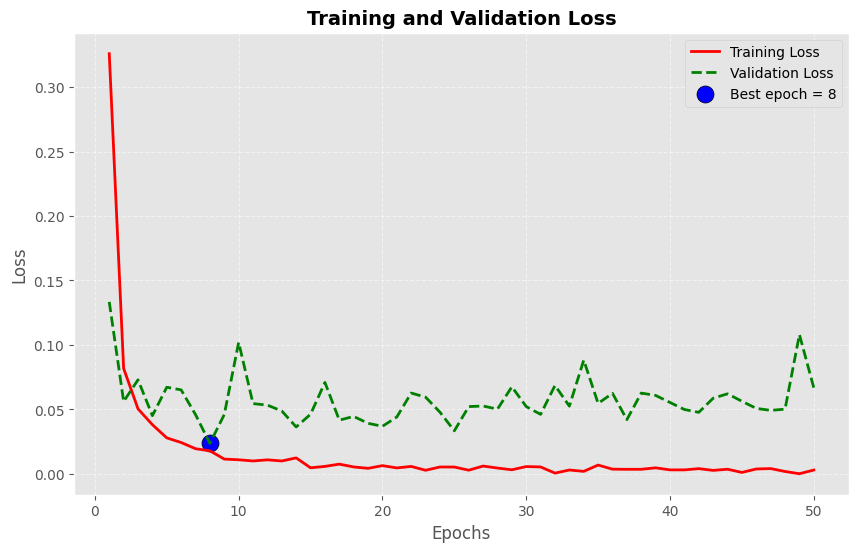

7


In [17]:
# Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(Epochs_X, tr_loss_X, color='red', label='Training Loss', linewidth=2)
plt.plot(Epochs_X, val_loss_X, color='green', label='Validation Loss', linestyle='--', linewidth=2)
plt.scatter(index_loss_X + 1, loss_lowest_X, s=150, c='blue', label=f'Best epoch = {index_loss_X + 1}', edgecolors='black')
plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=10)
plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.show()

print(np.argmin(val_loss_X))

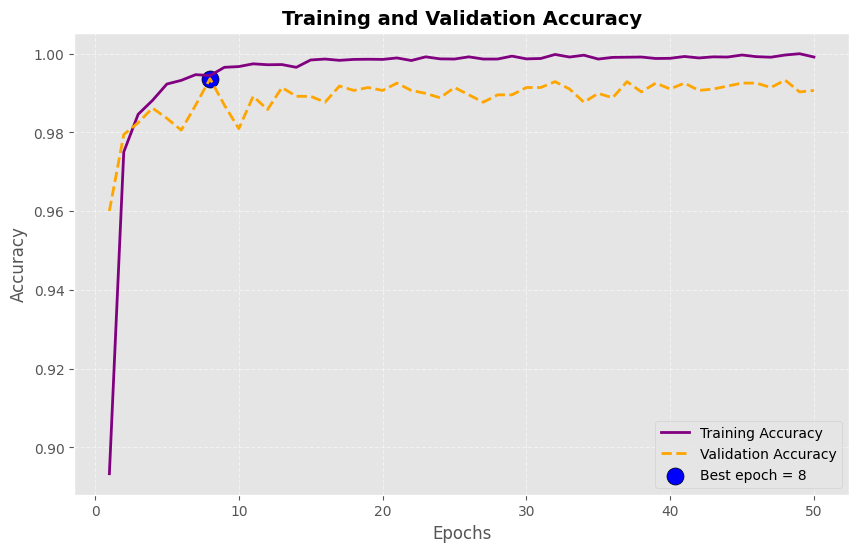

In [18]:
# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(Epochs_X, tr_acc_X, color='purple', label='Training Accuracy', linewidth=2)
plt.plot(Epochs_X, val_acc_X, color='orange', label='Validation Accuracy', linestyle='--', linewidth=2)
plt.scatter(index_acc_X + 1, acc_highest_X, s=150, c='blue', label=f'Best epoch = {index_acc_X + 1}', edgecolors='black')
plt.title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=10)
plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.show()

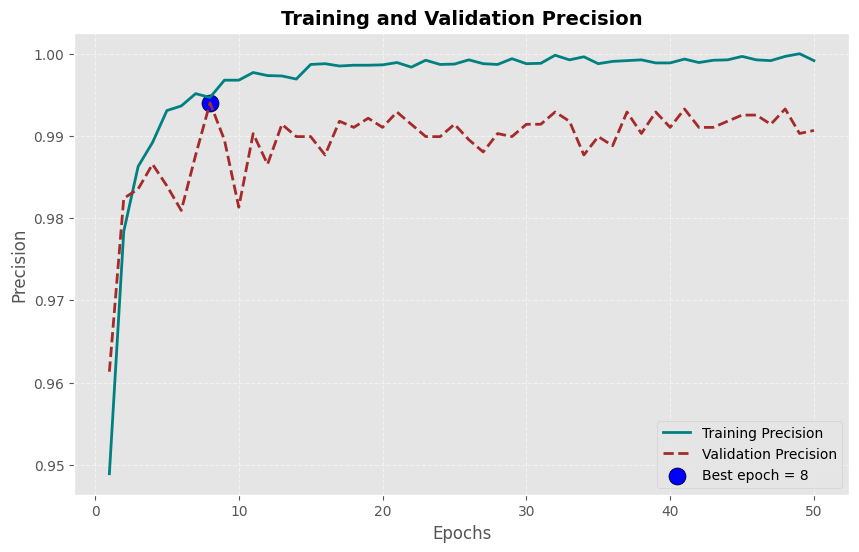

In [19]:
# Plot Training and Validation Precision
plt.figure(figsize=(10, 6))
plt.plot(Epochs_X, tr_per_X, color='teal', label='Training Precision', linewidth=2)
plt.plot(Epochs_X, val_per_X, color='brown', label='Validation Precision', linestyle='--', linewidth=2)
plt.scatter(index_precision_X + 1, pre_highest_X, s=150, c='blue', label=f'Best epoch = {index_precision_X + 1}', edgecolors='black')
plt.title('Training and Validation Precision', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.legend(fontsize=10)
plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.show()

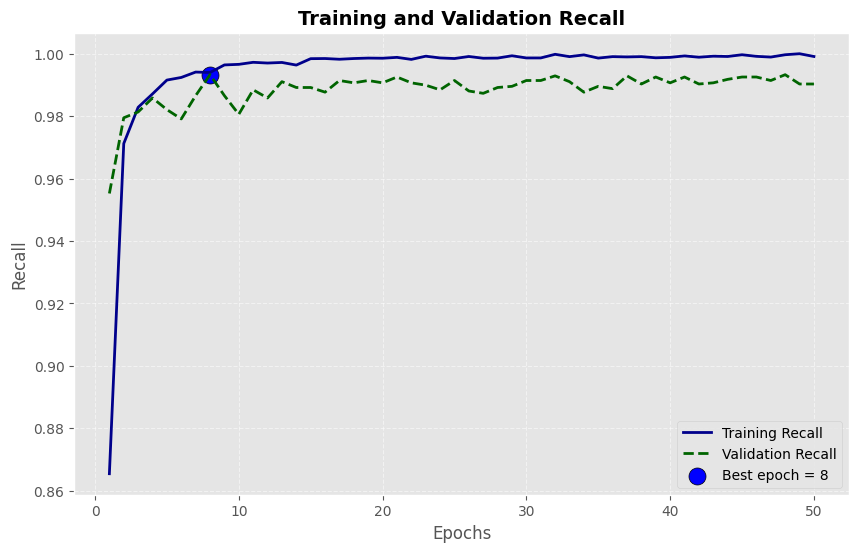

In [20]:
# Plot Training and Validation Recall
plt.figure(figsize=(10, 6))
plt.plot(Epochs_X, tr_recall_X, color='darkblue', label='Training Recall', linewidth=2)
plt.plot(Epochs_X, val_recall_X, color='darkgreen', label='Validation Recall', linestyle='--', linewidth=2)
plt.scatter(index_recall_X + 1, recall_highest_X, s=150, c='blue', label=f'Best epoch = {index_recall_X + 1}', edgecolors='black')
plt.title('Training and Validation Recall', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Recall', fontsize=12)
plt.legend(fontsize=10)
plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.show()

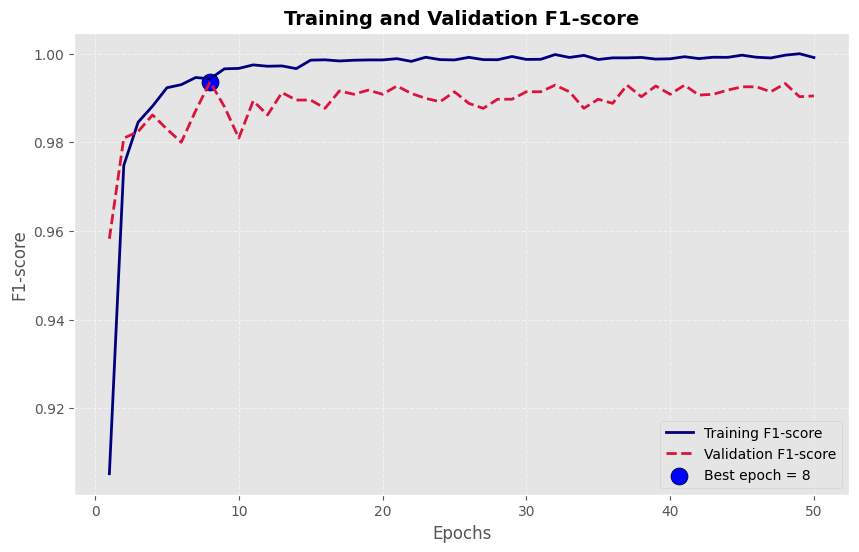

In [21]:
# Plot Training and Validation F1-score
plt.figure(figsize=(10, 6))
plt.plot(Epochs_X, tr_fscore_X, color='navy', label='Training F1-score', linewidth=2)
plt.plot(Epochs_X, val_fscore_X, color='crimson', label='Validation F1-score', linestyle='--', linewidth=2)
plt.scatter(index_fscore_X + 1, fscore_highest_X, s=150, c='blue', label=f'Best epoch = {index_fscore_X + 1}', edgecolors='black')
plt.title('Training and Validation F1-score', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('F1-score', fontsize=12)
plt.legend(fontsize=10)
plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.show()

In [22]:
#saving the histories for later use
with open("history_X.pkl", "wb") as f:
    pickle.dump(history_X, f)

Xmodel.save("Xmodel.keras")

In [23]:
# If not training first then run this code before plotting graphs
"""
# Load history from disk
with open("history_X.pkl", "rb") as f:
    history_X = pickle.load(f)


print(history_X.history.keys());
"""

'\n# Load history from disk\nwith open("history_X.pkl", "rb") as f:\n    history_X = pickle.load(f)\n\n\nprint(history_X.history.keys());\n'

In [24]:
# Define proper Input layer
inputs = Input(shape=img_shape)  

# Extract features before final Dense layers
Xmodel_features = Model(Xmodel.input, Xmodel.layers[-4].output)

# Pass input through each model
X_output = Xmodel_features(inputs)


# Create new model for feature extraction
feature_extractor = Model(inputs, X_output)
feature_extractor.trainable = False 

# Check the model summary
feature_extractor.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_1 (Functional)            │ (None, 2048)                │      20,861,480 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,861,480 (79.58 MB)

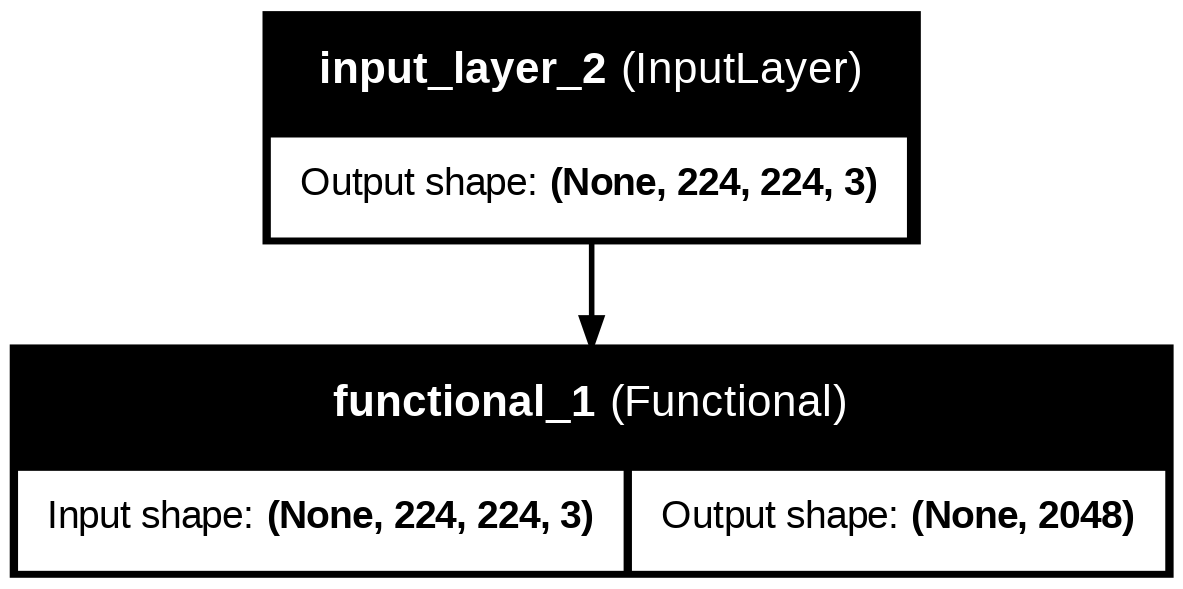

In [25]:
# Plot the model with additional details
plot_model(
    feature_extractor,
    to_file="feature_extractor_plot.png",
    show_shapes=True,  # Shows input/output shapes for layers.
    show_layer_names=True,  # Shows layer names.
    show_layer_activations=True,  # Showsimport networkx as nx
)

In [26]:
feature_extractor.save("feature_extractor.keras")

In [27]:
#feature_extractor = tf.keras.models.load_model("feature_extractor.keras")

In [28]:
from tqdm import tqdm

def extract_features(generator, model):
    features, labels = [], []
    for i in tqdm(range(len(generator)), desc="Extracting Features"):
        x, y = generator[i]
        features.append(model.predict(x, verbose=0))
        labels.append(y)
    
    labels = np.vstack(labels)
    y = np.argmax(labels, axis=1) if labels.ndim == 2 else labels
    return np.vstack(features), y

print("Extracting features from train data")
X_train, y_train = extract_features(train_data, feature_extractor)
print("Extracting features from validation data")
X_val, y_val = extract_features(validation_data, feature_extractor)
print("Extracting features from test data")
X_test, y_test = extract_features(test_data, feature_extractor)


Extracting features from train data


Extracting Features: 100%|██████████| 670/670 [05:23<00:00,  2.07it/s]


Extracting features from validation data


Extracting Features: 100%|██████████| 84/84 [00:42<00:00,  1.98it/s]


Extracting features from test data


Extracting Features: 100%|██████████| 84/84 [00:32<00:00,  2.60it/s]


In [ ]:
# Save extracted features to a file
with open("features.pkl", "wb") as f:
    pickle.dump((X_train, y_train, X_val, y_val, X_test, y_test), f)

# Load extracted features from a file
#with open("features.pkl", "rb") as f:
    #X_train, y_train, X_val, y_val, X_test, y_test = pickle.load(f)

In [7]:
# Load extracted features from a file
from sklearn.feature_selection import SelectPercentile, f_classif
with open("features.pkl", "rb") as f:
    X_train, y_train, X_val, y_val, X_test, y_test = pickle.load(f)

print(f"Original number of features: {X_train.shape[1]}")
selector = SelectPercentile(f_classif, percentile=25)
X_train = selector.fit_transform(X_train, y_train)
X_val = selector.transform(X_val)
X_test = selector.transform(X_test)
print(f"Selected number of features: {X_train.shape[1]}")

Original number of features: 2048
Selected number of features: 512


In [8]:
# Function to evaluate a model
def evaluate_model(model, X_test, y_test, model_name):
    """
    Evaluate a single model and return performance metrics.
    """
    # Predict labels
    y_pred = model.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="binary" if len(np.unique(y_test)) == 2 else "weighted")
    recall = recall_score(y_test, y_pred, average="binary" if len(np.unique(y_test)) == 2 else "weighted")
    f1 = f1_score(y_test, y_pred, average="binary" if len(np.unique(y_test)) == 2 else "weighted")

    # Print metrics
    print(f"--- {model_name} ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}\n")

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels,
                        annot_kws={'size': 14}, cbar=True, linewidths=0.5, linecolor='gray',
                        cbar_kws={'shrink': 0.8})  # Add color bar and adjust its size

    # Add title and labels
    plt.title('Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Predicted Label', fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=14, fontweight='bold')

    # Adjust tick labels
    plt.xticks(fontsize=12, rotation=45 if len(labels) > 5 else 0)  # Rotate x-labels if too many
    plt.yticks(fontsize=12)
    plt.title(f"Confusion Matrix: {model_name}")
    # Improve layout
    plt.tight_layout()
    plt.show()

    return {
        "model_name": model_name,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
    }

In [9]:
# Create an empty list for storing all the Evaluation Results
evaluation_results = []

Using Default Parameters: {'n_neighbors': 3, 'metric': 'euclidean', 'weights': 'distance'}
--- K-Nearest Neighbour ---
Accuracy: 0.9896
Precision: 0.9896
Recall: 0.9896
F1 Score: 0.9896



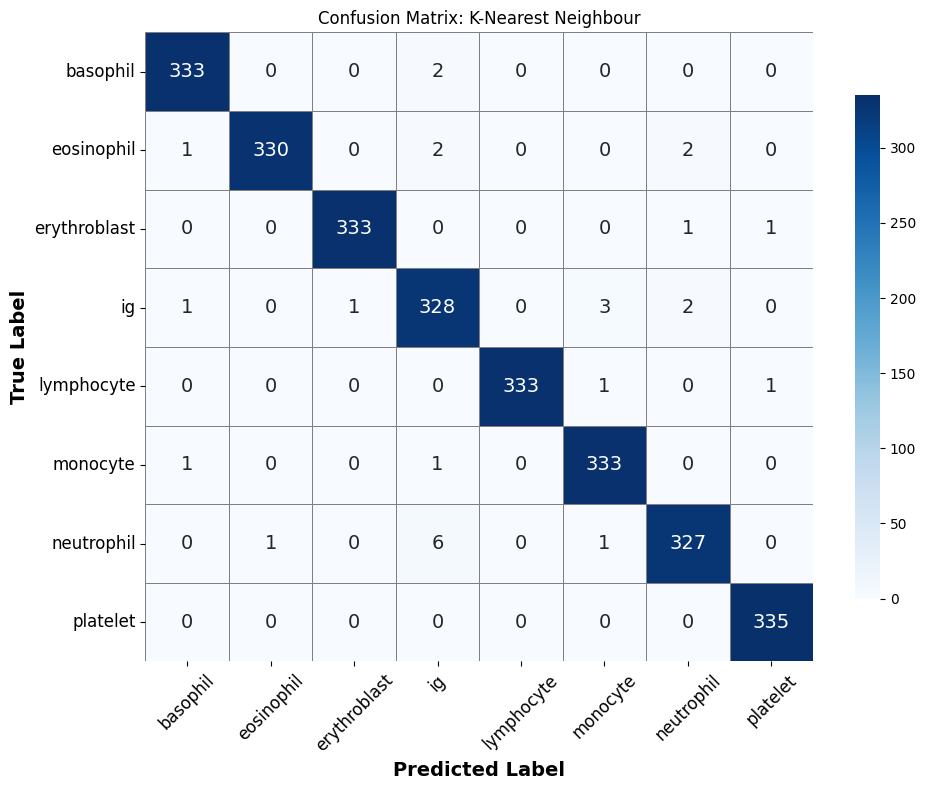

In [10]:
# Option to use Grid Search or not
use_grid_search = False  # Set to False to skip grid search and use default parameters
param_grid = {
    'n_neighbors': [3, 5, 7, 11, 15],  # Number of neighbors
    'weights': ['uniform', 'distance'],  # Weight function for prediction
    'metric': ['euclidean', 'manhattan', 'minkowski'],  # Distance metric
}

knn = KNeighborsClassifier()

if use_grid_search:
    grid_search = GridSearchCV(estimator=knn, 
                               param_grid=param_grid, 
                               cv=3,  
                               verbose=2, 
                               n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    print(f"Best Parameters from Grid Search: {best_params}")
    knn = grid_search.best_estimator_
    
else:
    # Default parameters when not using grid search
    default_param = {
        'n_neighbors': 3,    
        'metric': 'euclidean',
        'weights': 'distance'
    }
    print(f"Using Default Parameters: {default_param}")
    knn = KNeighborsClassifier(n_neighbors=default_param['n_neighbors'],
                               weights=default_param['weights'],
                               metric=default_param['metric'])
    knn.fit(X_train, y_train)
evaluation_results.append(evaluate_model(knn, X_test, y_test, "K-Nearest Neighbour"))


In [11]:
# Save the trained model to a file
with open('knn_model.pkl', 'wb') as file:
    pickle.dump(knn, file)

#with open('knn_model.pkl', 'rb') as file:
    #knn_loaded = pickle.load(file)

Using Default Parameters: {'n_estimators': 50, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True}
--- Random Forest ---
Accuracy: 0.9888
Precision: 0.9888
Recall: 0.9888
F1 Score: 0.9888



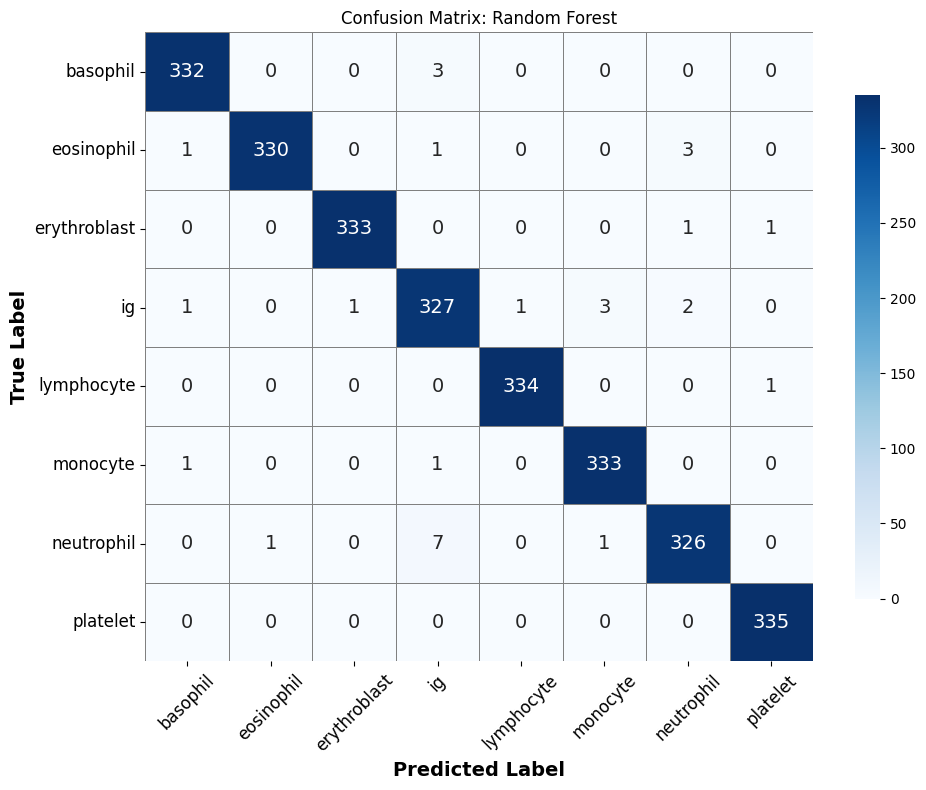

In [12]:
# Option to use Grid Search or not
use_grid_search = False  # Set to False to skip grid search and use default parameters

param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4],    # Minimum number of samples required at a leaf node
    'bootstrap': [True, False],      # Whether bootstrap samples are used when building trees
}

rf = RandomForestClassifier(random_state=42)
if use_grid_search:
    grid_search = GridSearchCV(estimator=rf, 
                               param_grid=param_grid, 
                               cv=3,
                               verbose=2, 
                               n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    print(f"Best Parameters from Grid Search: {best_params}")
    rf = grid_search.best_estimator_
else:
    best_params = {
        'n_estimators': 50,      # Default number of trees
        'max_depth': None,        # No limit on the depth of trees
        'min_samples_split': 2,   # Default min samples required to split a node
        'min_samples_leaf': 1,    # Default min samples required at a leaf node
        'bootstrap': True         # Use bootstrap samples
    }
    print(f"Using Default Parameters: {best_params}")    
    rf = RandomForestClassifier(n_estimators=best_params['n_estimators'],
                                max_depth=best_params['max_depth'],
                                min_samples_split=best_params['min_samples_split'],
                                min_samples_leaf=best_params['min_samples_leaf'],
                                bootstrap=best_params['bootstrap'],
                                random_state=42)
    rf.fit(X_train, y_train)

# Evaluate the model (whether tuned or default)
evaluation_results.append(evaluate_model(rf, X_test, y_test, "Random Forest"))

Using Default Parameters: {'C': 0.1, 'kernel': 'linear', 'gamma': 'scale', 'degree': 3}
--- Support Vector Classifier ---
Accuracy: 0.9896
Precision: 0.9896
Recall: 0.9896
F1 Score: 0.9896



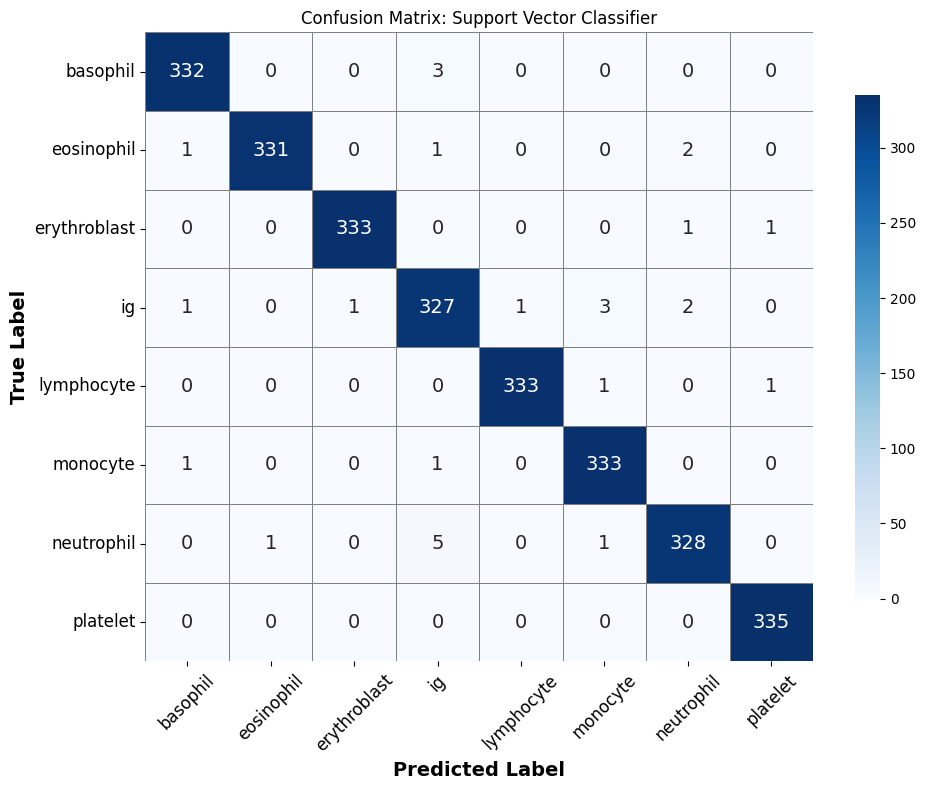

In [13]:
use_grid_search = False  # Set to False to skip grid search and use default parameters
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly'],  # Different kernel types
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],  # Kernel coefficient for 'rbf', 'poly' kernels
    'degree': [3, 4, 5],  # Degree for 'poly' kernel (only relevant if kernel='poly')
}
svm = SVC(probability=True)
if use_grid_search:
    grid_search = GridSearchCV(estimator=svm, 
                               param_grid=param_grid, 
                               cv=3, 
                               verbose=2, 
                               n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    print(f"Best Parameters from Grid Search: {best_params}")
    svm = grid_search.best_estimator_
else:
    best_params = {
        'C': 0.1,
        'kernel': 'linear',
        'gamma': 'scale',
        'degree': 3
    }
    print(f"Using Default Parameters: {best_params}")
    svm = SVC(C=best_params['C'], 
                     kernel=best_params['kernel'], 
                     gamma=best_params['gamma'], 
                     degree=best_params['degree'], 
                     probability=True)
    svm.fit(X_train, y_train)

evaluation_results.append(evaluate_model(svm, X_test, y_test, "Support Vector Classifier"))

Using Default Parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs', 'max_iter': 1000}
--- Logistic Regression ---
Accuracy: 0.9892
Precision: 0.9892
Recall: 0.9892
F1 Score: 0.9892



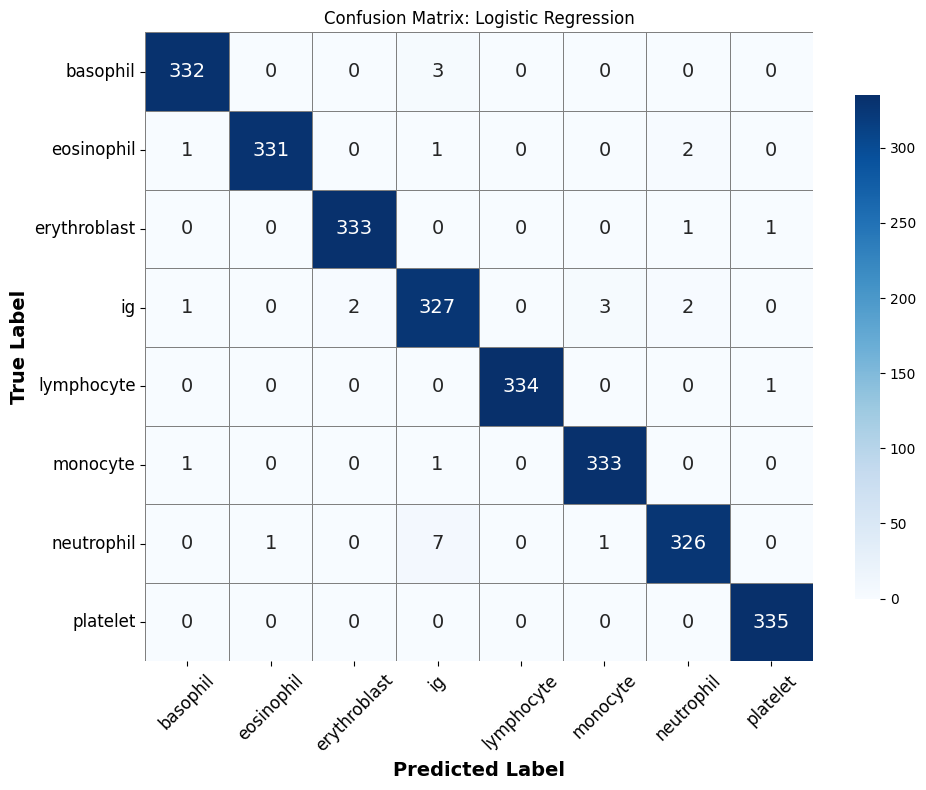

In [14]:
use_grid_search = False  # Set to False to skip grid search and use default parameters
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'penalty': ['l2', 'l1'],  # Regularization type
    'solver': ['liblinear', 'lbfgs', 'saga'],  # Solver algorithm
    'max_iter': [1000, 5000],  # Maximum iterations for optimization
}

logreg = LogisticRegression(random_state=42)

if use_grid_search:
    grid_search = GridSearchCV(estimator=logreg, 
                               param_grid=param_grid, 
                               cv=3, 
                               verbose=2, 
                               n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    print(f"Best Parameters from Grid Search: {best_params}")
    logreg = grid_search.best_estimator_
else:
    default_param = {
        'C': 0.1,
        'penalty': 'l2',
        'solver': 'lbfgs',
        'max_iter': 1000
    }
    print(f"Using Default Parameters: {default_param}")
    logreg = LogisticRegression(C=default_param['C'], 
                                 penalty=default_param['penalty'], 
                                 solver=default_param['solver'], 
                                 max_iter=default_param['max_iter'],
                                 random_state=42)
    logreg.fit(X_train, y_train)

evaluation_results.append(evaluate_model(logreg, X_test, y_test, "Logistic Regression"))

Using Default Parameters (GaussianNB): {'var_smoothing': 0.0004}
--- Naive Bayes (Gaussian) ---
Accuracy: 0.9869
Precision: 0.9869
Recall: 0.9869
F1 Score: 0.9869



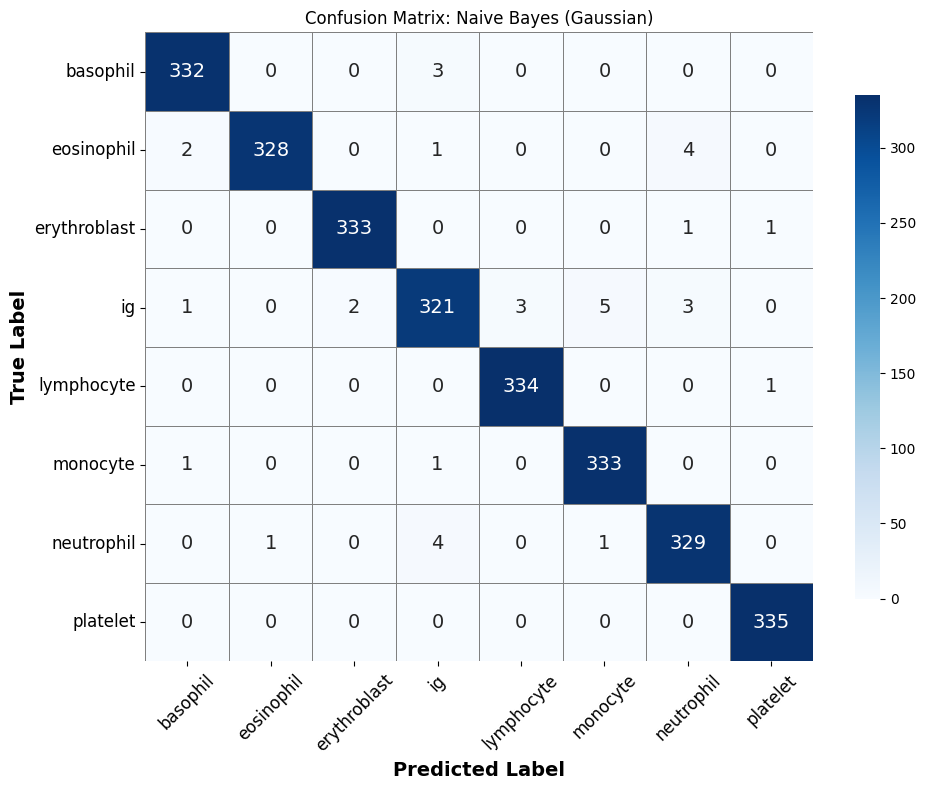

In [15]:
use_grid_search = False  # Set to False to skip grid search and use default parameters

# Grid search parameters
param_grid_gnb = {'var_smoothing': np.logspace(-9, 0, 100)}

# Initialize model
nb = GaussianNB()

if use_grid_search:
    grid_search = GridSearchCV(estimator=nb, 
                               param_grid=param_grid_gnb, 
                               cv=3, 
                               verbose=2, 
                               n_jobs=-1)
    grid_search.fit(X_train, y_train)    
    best_params = grid_search.best_params_
    print(f"Best Parameters from Grid Search (GaussianNB): {best_params}")
    nb = grid_search.best_estimator_
else:
    default_param = {'var_smoothing': 0.0004}
    nb = GaussianNB(var_smoothing=default_param['var_smoothing'])
    print(f"Using Default Parameters (GaussianNB): {default_param}")
    nb.fit(X_train, y_train)

evaluation_results.append(evaluate_model(nb, X_test, y_test, "Naive Bayes (Gaussian)"))

Using Default Parameters (MultinomialNB): {'alpha': 10.0}
--- Naive Bayes (Multinomial) ---
Accuracy: 0.9854
Precision: 0.9855
Recall: 0.9854
F1 Score: 0.9854



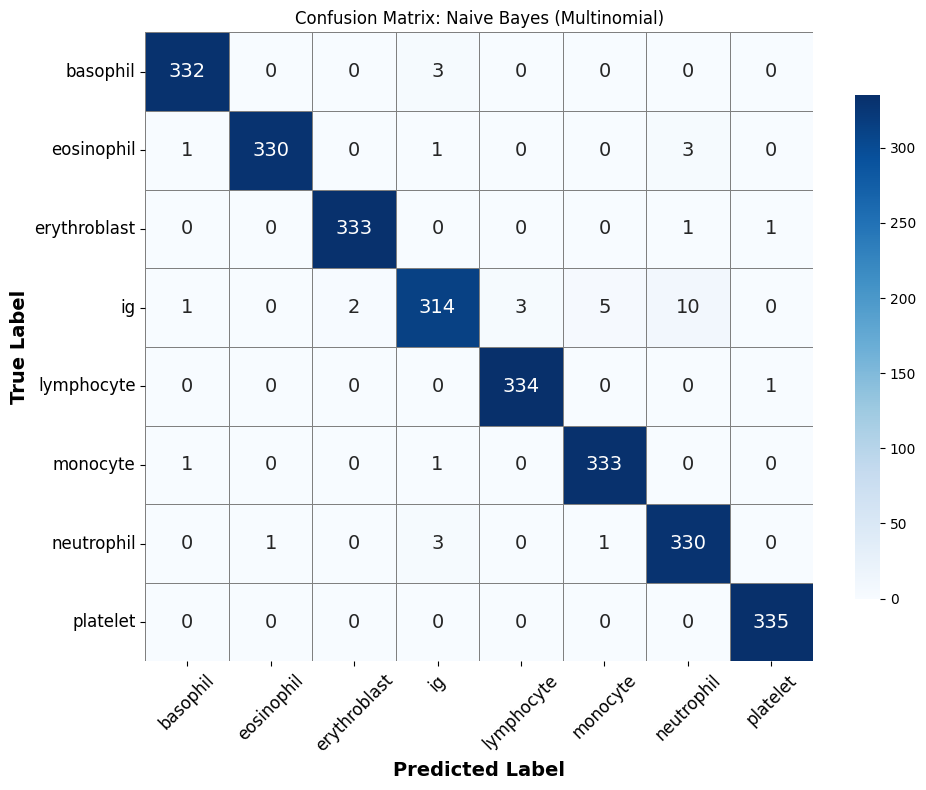

In [16]:
from sklearn.naive_bayes import MultinomialNB

use_grid_search = False  # Set to False to skip grid search and use default parameters
# Grid search parameters
param_grid_mnb = {'alpha': np.logspace(-3, 1, 10)}

# Initialize model
nb = MultinomialNB()

if use_grid_search:
    grid_search = GridSearchCV(estimator=nb, 
                               param_grid=param_grid_mnb, 
                               cv=3, 
                               verbose=2, 
                               n_jobs=-1)
    grid_search.fit(X_train, y_train)    
    best_params = grid_search.best_params_
    print(f"Best Parameters from Grid Search (MultinomialNB): {best_params}")
    nb = grid_search.best_estimator_
else:
    default_param = {'alpha': 10.0}
    nb = MultinomialNB(alpha=default_param['alpha'])
    print(f"Using Default Parameters (MultinomialNB): {default_param}")
    nb.fit(X_train, y_train)

evaluation_results.append(evaluate_model(nb, X_test, y_test, "Naive Bayes (Multinomial)"))

Using Default Parameters (BernoulliNB): {'alpha': 0.001, 'binarize': 0.25}
--- Naive Bayes (Bernoulli) ---
Accuracy: 0.9873
Precision: 0.9874
Recall: 0.9873
F1 Score: 0.9873



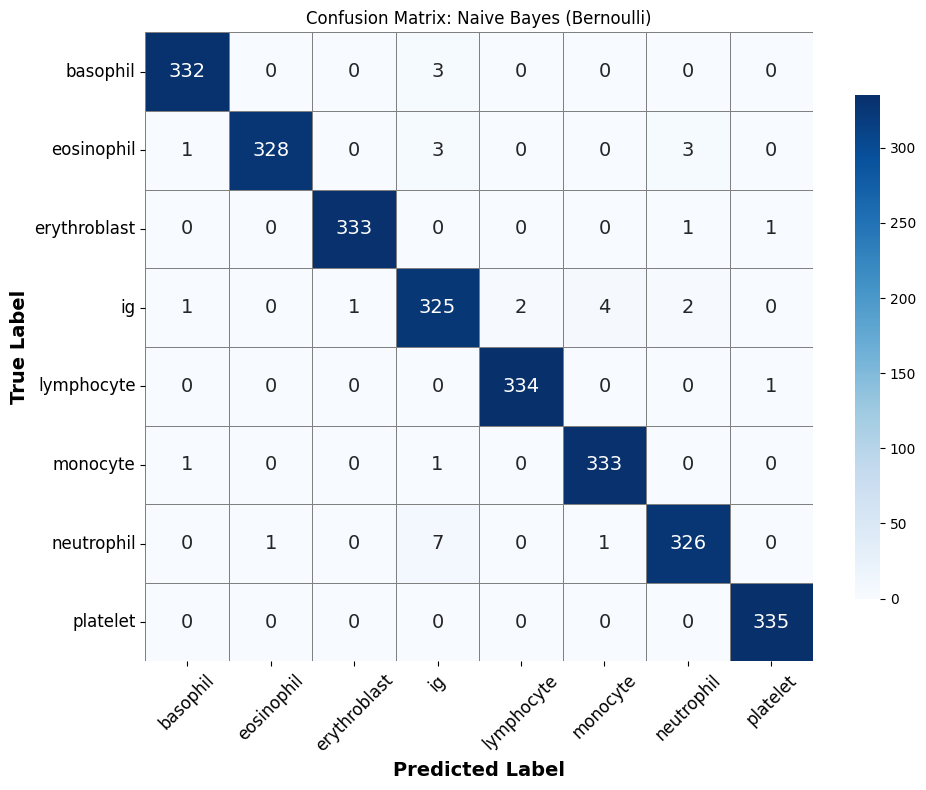

In [17]:
from sklearn.naive_bayes import BernoulliNB

use_grid_search = False  # Set to False to skip grid search and use default parameters
# Grid search parameters
param_grid_bnb = {'alpha': np.logspace(-3, 1, 10), 'binarize': np.linspace(0, 1, 5)}

# Initialize model
nb = BernoulliNB()

if use_grid_search:
    grid_search = GridSearchCV(estimator=nb, 
                               param_grid=param_grid_bnb, 
                               cv=3, 
                               verbose=2, 
                               n_jobs=-1)
    grid_search.fit(X_train, y_train)    
    best_params = grid_search.best_params_
    print(f"Best Parameters from Grid Search (BernoulliNB): {best_params}")
    nb = grid_search.best_estimator_
else:
    default_param = {'alpha': 0.001, 'binarize': 0.25}
    nb = BernoulliNB(alpha=default_param['alpha'], binarize=default_param['binarize'])
    print(f"Using Default Parameters (BernoulliNB): {default_param}")
    nb.fit(X_train, y_train)

evaluation_results.append(evaluate_model(nb, X_test, y_test, "Naive Bayes (Bernoulli)"))

Using Default Parameters: {'hidden_layer_sizes': (512, 256), 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'constant', 'max_iter': 1000}
--- MultiLayer Perceptron ---
Accuracy: 0.9881
Precision: 0.9881
Recall: 0.9881
F1 Score: 0.9881



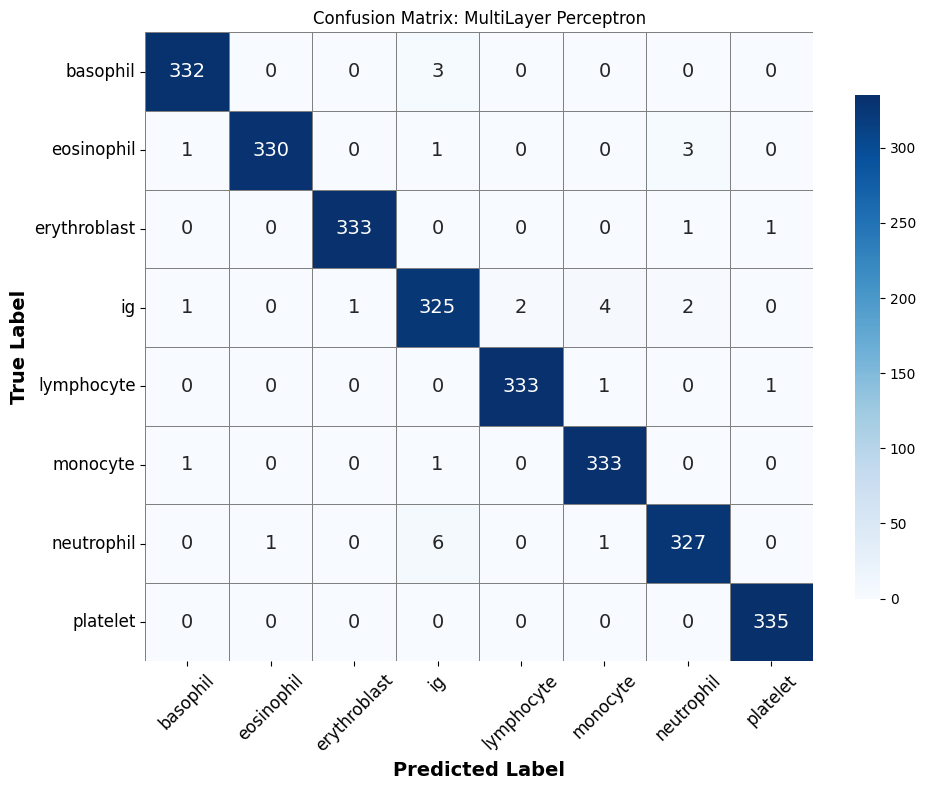

In [ ]:
# Option to use Grid Search or not
use_grid_search = False  # Set to False to skip grid search and use default parameters

param_grid = {
    'hidden_layer_sizes': [(64,32), (128,64), (256,128), (512, 256)],  # Different architectures of the neural network
    'activation': ['relu', 'tanh'],  # Activation function
    'solver': ['adam', 'sgd'],       # Solver for weight optimization
    'alpha': [0.0001, 0.001, 0.01],  # L2 regularization
    'learning_rate': ['constant', 'invscaling', 'adaptive'],  # Learning rate schedule
    'max_iter': [1000, 5000],         # Maximum number of iterations for optimization
}

mlp = MLPClassifier(random_state=42)

if use_grid_search:
    grid_search = GridSearchCV(estimator=mlp, 
                               param_grid=param_grid, 
                               cv=3, 
                               verbose=2, 
                               n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    print(f"Best Parameters from Grid Search: {best_params}")
    mlp = grid_search.best_estimator_
else:
    best_params = {
        'hidden_layer_sizes': (512, 256),
        'activation': 'relu',
        'solver': 'sgd',
        'alpha': 0.0001,
        'learning_rate': 'constant',
        'max_iter': 1000
    }
    print(f"Using Default Parameters: {best_params}")
    mlp = MLPClassifier(hidden_layer_sizes=best_params['hidden_layer_sizes'], 
                        activation=best_params['activation'], 
                        solver=best_params['solver'], 
                        alpha=best_params['alpha'], 
                        learning_rate=best_params['learning_rate'], 
                        max_iter=best_params['max_iter'], 
                        random_state=42)
    mlp.fit(X_train, y_train)

evaluation_results.append(evaluate_model(mlp, X_test, y_test, "MultiLayer Perceptron"))


Using Default ExtraTrees Parameters: {'n_estimators': 100, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'gini', 'random_state': 42}
--- ExtraTrees ---
Accuracy: 0.9888
Precision: 0.9889
Recall: 0.9888
F1 Score: 0.9888



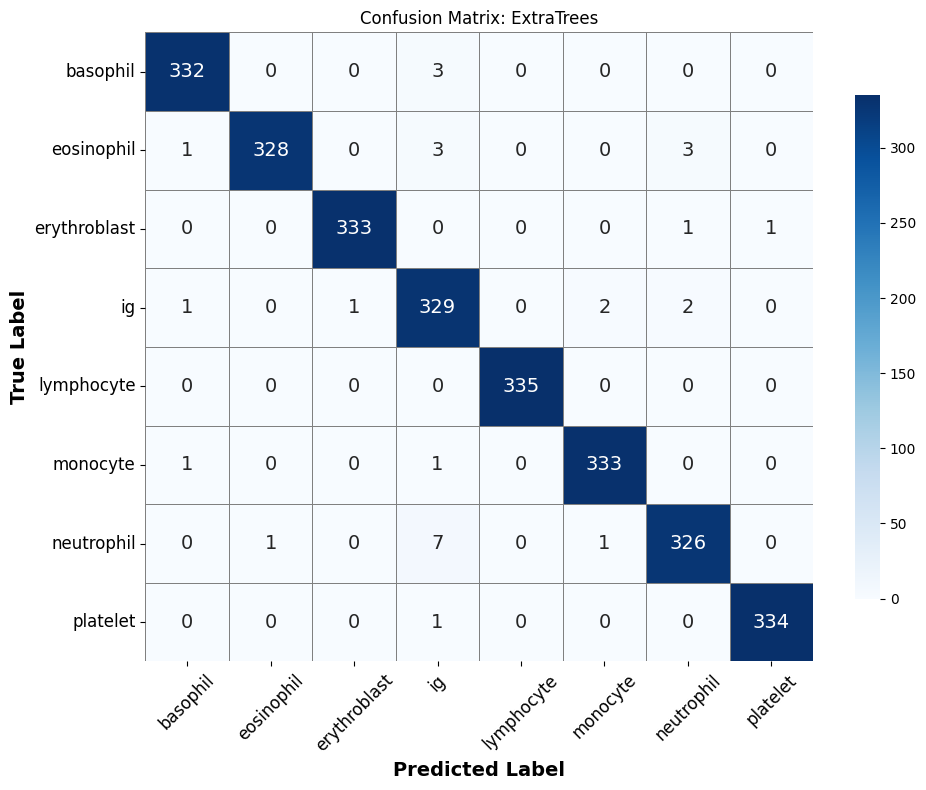

In [19]:
# Option to use Grid Search or not
use_grid_search = False  # Set to False to skip grid search and use default parameters
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}
default_et_params = {
    'n_estimators': 100,
    'max_depth': 5,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'criterion': 'gini',
    'random_state': 42
}

et = ExtraTreesClassifier(**default_et_params)

if use_grid_search:
    grid_search = GridSearchCV(estimator=et, 
                               param_grid=param_grid, 
                               cv=3, 
                               verbose=2, 
                               n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    print(f"Best Parameters from Grid Search: {best_params}")
    et = grid_search.best_estimator_
else:
    print(f"Using Default ExtraTrees Parameters: {default_et_params}")
    et.fit(X_train, y_train)

evaluation_results.append(evaluate_model(et, X_test, y_test, "ExtraTrees"))

In [20]:
# Summarize results
summary_df = pd.DataFrame(evaluation_results)
print("\nSummary of Model Performance:")
print(summary_df.sort_values(by="accuracy", ascending=True))


Summary of Model Performance:
                  model_name  accuracy  precision    recall  f1_score
5  Naive Bayes (Multinomial)  0.985448   0.985497  0.985448  0.985393
4     Naive Bayes (Gaussian)  0.986940   0.986942  0.986940  0.986916
6    Naive Bayes (Bernoulli)  0.987313   0.987370  0.987313  0.987321
7      MultiLayer Perceptron  0.988060   0.988084  0.988060  0.988060
1              Random Forest  0.988806   0.988846  0.988806  0.988812
8                 ExtraTrees  0.988806   0.988928  0.988806  0.988832
3        Logistic Regression  0.989179   0.989219  0.989179  0.989186
0        K-Nearest Neighbour  0.989552   0.989603  0.989552  0.989561
2  Support Vector Classifier  0.989552   0.989579  0.989552  0.989557
